# Maze Solver

A **maze** is a rectangular array of cells. The **agent** may move across the cells of the mase. By stepping into a cell, the agent receives a reward (or pays a penalty). Some cells are **terminal**, when stepping into a terminal cell the agent finishes the game (exits the maze). The **goal** of the agent is to maximize the total cummulative reward (minimize the total cummulative loss).

In addition to **regular** and **terminal** cells, there are also **walls**: walls are forbidden areas of the maze. The agent canot step onto a wall cell.

<div class="alert alert-block alert-info">
<b>The Assignment:</b> 
Implement the maze environment and develop optimal decision policy for moving across the maze.
</div>

## Basic Imports

In [1]:
from abc import ABC, abstractmethod
from typing import Iterable
from copy import copy

import numpy as np
import matplotlib.pyplot as plt

from random import random

## The Maze

Let us implement the maze first, so that later we can implement solution algorithm(s).

We will start by implementing individual cells, and the we will collect them all within a single maze board.

### Implementing Individual Cells

In [2]:
class Cell(ABC):
    """Abstract base class for all maze cells."""

    @abstractmethod
    def get_reward(self) -> float:
        """The reward an agent receives when stepping onto this cell."""
        pass

    def is_steppable(self) -> bool:
        """Checks if an agent can step onto this cell.

        Regular and terminal cells are steppable.
        Walls are not steppable.
        """
        return True

    def is_terminal(self) -> bool:
        """Checks if the cell is terminal.

        When stepping onto a terminal cell the agent exits
        the maze and finishes the game.
        """
        return False

    def has_value(self) -> bool:
        """Check if the cell has value.
        
        The value is defined for regular cells and terminal cells,
        but not for walls. 
        """
        return True

We will use the `Cell` class to derive all other cell classes. Please note that it may seem that `is_steppable` and `has_value` are essentially synonims, but this is not true in general.

Consider for example **teleport cells**. When stepping onto such a cell the agent is instantinuously transported into another, linked cell. Such a cell is different from the cell to which it is linked. It has a distinct geometrical location, and is steppable. However, from routing point of view it is just an alias for the linked cell, and so there is no reason for it to have a distinct value.

Let us now implement some basic types of cells:

In [3]:
class RegularCell(Cell):
    """A common, non-terminal, steppable cell."""

    def __init__(self, reward: float):
        self.reward = reward

    def get_reward(self) -> float:
        return self.reward


class TerminalCell(Cell):
    """A terminal cell."""

    def __init__(self, reward: float):
        self.reward = reward

    def get_reward(self) -> float:
        return self.reward

    def is_terminal(self) -> bool:
        return True

    def has_value(self) -> bool:
        return False


class WallCell(Cell):
    """A non-steppable cell."""

    def get_reward(self) -> float:
        return 0

    def is_steppable(self) -> bool:
        return False

    def has_value(self) -> bool:
        return False

### Implementing the Maze Board

The maze board is essentially a rectangular grid of cells. The board is not concerned with the type of individual cells, it is only interested in their relative arrangement.

In [4]:
class Board:

    @staticmethod
    def process_cells(cells: list[list[Cell]]):
        cells = [list(row) for row in cells] if cells else []
        if not cells:
            raise Exception("Number of rows in a board must be at least one.")
        if not cells[0]:
            raise Exception("There has to be at least one column.")
        rows_no = len(cells)
        cols_no = len(cells[0])
        for row in cells:
            if not row or len(row) != cols_no:
                raise Exception(
                    "Each row in a a board must have the same number of columns. ")
        return rows_no, cols_no, cells

    def process_pos(self, pos):
        r, c = pos
        if r < 0 or r >= self.rows_no:
            raise Exception("Invalid row position.")
        if c < 0 or c >= self.cols_no:
            raise Exception("Invalid column position.")
        if not cells[r][c].is_steppable():
            raise Exception("Invalid position: unsteppable cell.")
        return r, c
    
    def __init__(self, cells: Iterable[Iterable[Cell]], pos: tuple[int, int]):
        rows_no, cols_no, cells = Board.process_cells(cells)
        self.cells = cells
        self.rows_no = rows_no
        self.cols_no = cols_no
        r, c = self.process_pos(pos)
        self.row = r
        self.col = c

    def __getitem__(self, key: tuple[int, int]) -> Cell:
        r, c = key
        return self.cells[r][c]

    def set_position(self, pos):
        r, c = self.process_pos(pos)
        self.row = r
        self.col = c

    def current(self):
        return self[self.row, self.col]

    def move_up(self):
        if self.row != 0 and \
           self[self.row-1, self.col].is_steppable():
            self.row = self.row-1

    def move_down(self):
        if self.row != self.rows_no-1 and \
           self[self.row+1, self.col].is_steppable():
            self.row = self.row+1

    def move_left(self):
        if self.col != 0 and \
           self[self.row, self.col-1].is_steppable():
            self.col = self.col-1

    def move_right(self):
        if self.col != self.cols_no-1 and \
           self[self.row, self.col+1].is_steppable():
            self.col = self.col+1

    def move(self, direction):
        if direction == 0:
            self.move_right()
        elif direction == 1:
            self.move_up()
        elif direction == 2:
            self.move_left()
        elif direction == 3:
            self.move_down()
        else:
            raise Exception("Invalid direction.")

    def get_states(self):
        states = []
        for r in range(self.rows_no):
            for c in range(self.cols_no):
                if self[r, c].is_steppable():
                    states.append((r, c))
        return states        

In [5]:
def int_to_cell(code: int) -> Cell:
    if code == 0:
        return RegularCell(-1)
    elif code == 1:
        return RegularCell(-10)
    elif code == 2:
        return WallCell()
    elif code == 3:
        return TerminalCell(-1)

In [6]:
cell_codes = np.random.choice(4, size=(8, 8), p=[0.7, 0.1, 0.1, 0.1])
print(cell_codes)

[[0 0 0 0 0 0 2 0]
 [0 0 0 1 3 0 0 0]
 [3 3 3 0 0 0 2 1]
 [0 2 3 2 0 0 0 0]
 [1 1 0 0 0 0 0 0]
 [0 0 3 0 0 0 1 0]
 [0 3 0 2 0 0 2 2]
 [0 1 0 0 0 0 2 1]]


In [7]:
def draw_board(board: Board, draw_pos=True):
    board_img = np.ones(shape=(board.rows_no, board.cols_no, 3), dtype=np.uint8)    
    for i in range(board.rows_no):
        for j in range(board.cols_no):
            if isinstance(board[i, j], RegularCell):
                if board[i, j].get_reward() == -1:
                    board_img[i, j, :] = [255, 255, 255] # Regular cell
                else:
                    board_img[i, j, :] = [255, 0, 0] # Regular cell with penalty
            elif isinstance(board[i, j], WallCell):
                board_img[i, j, :] = [0, 0, 0] # Wall cell
            else:
                board_img[i, j, :] = [0, 0, 255] # Terminal cell
    # board_img[board.row, board.col, :] = [255, 255, 0]
    plt.imshow(board_img)
    if draw_pos:
        plt.text(board.col-0.1, board.row+0.1, "X", fontweight="bold")

In [8]:
cells = [[int_to_cell(cell_codes[i, j]) for i in range(cell_codes.shape[0])] for j in range(cell_codes.shape[1])]

In [9]:
board = Board(cells, (0, 0))

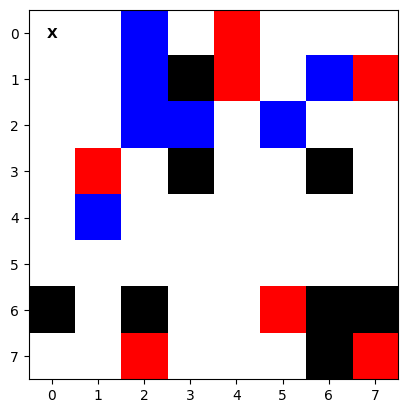

In [10]:
draw_board(board)

In [11]:
states = board.get_states()

In [12]:
values = {s: -10*random() for s in states}

In [13]:
for s in values:
    if isinstance(board[s], TerminalCell):
        values[s] = 0

In [14]:
board.current()

In [15]:
def compute_update(board, s, values, gamma):
    rhs = []
    for a in [0, 1, 2, 3]:
        board.set_position(s)
        board.move(a)
        rhs.append(board.current().get_reward() + gamma*values[(board.row, board.col)])
    return max(rhs)

In [16]:
def draw_values(board, values):
    draw_board(board)
    for s in values:
        plt.text(s[1]-0.25, s[0]+0.1, f"{values[s]:.1f}")

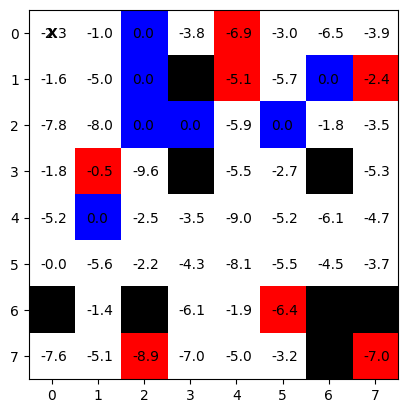

In [17]:
draw_values(board, values)

In [18]:
# new_values = copy(values)
for s in board.get_states():
    if not isinstance(board[s], TerminalCell):
        # new_values[s] = compute_update(board, s, values, 1)
        values[s] = compute_update(board, s, values, 1)
# values = new_values

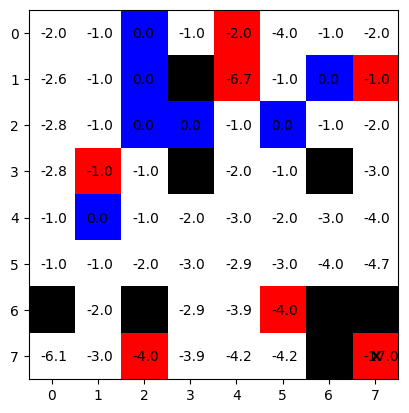

In [19]:
draw_values(board, values)

In [20]:
q_values = { (s, a) : -10*random() for s in states for a in range(4) }

In [21]:
def compute_q_update(board, s, a, q_values, gamma):
    rhs = []
    for a_next in [0, 1, 2, 3]:
        board.set_position(s)
        board.move(a)
        r = board.current().get_reward()
        rhs.append(r + gamma*q_values[((board.row, board.col), a_next)])
    return max(rhs)

In [22]:
for s in board.get_states():
    if not isinstance(board[s], TerminalCell):
        for a in range(4):
            # new_values[s] = compute_update(board, s, values, 1)
            q_values[(s, a)] = compute_q_update(board, s, a, q_values, 1)
